In [155]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import MultiLabelBinarizer
import torch
import random

# from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import f1_score

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# # import nltk
# # from nltk.corpus import stopwords, wordnet
# # from nltk.tokenize import word_tokenize


# from torch.utils.data import Dataset, DataLoader

# import pickle

## Загрузка и анализ датасета

In [156]:
# Задаем seed для воспроизводимости случайных функций
seed = 110
# seed = random.randint(1, 1000)
print(f'seed: {seed}')

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

seed: 110


In [157]:
# Загрузка данных
data = pd.read_csv('train.csv')

In [158]:
# pd.options.display.max_colwidth = None

In [159]:
# data

In [160]:
data = data.rename({'Фильм': 'movie', 'Сюжет': 'plot', 'Жанры': 'genres', 'Описание': 'description'}, axis=1)

In [161]:
# Проверка дубликатов
duplicates = data.duplicated()  # Булевый массив для дубликатов

# Счетчик дубликатов
num_duplicates = duplicates.sum()

# Общее количество строк
total_rows = data.shape[0]

# Процент дубликатов
duplicate_percentage = (num_duplicates / total_rows) * 100

# Вывод результатов
print(f"Количество дубликатов: {num_duplicates}")
print(f"Общее количество строк: {total_rows}")
print(f"Процент дубликатов: {duplicate_percentage:.2f}%")

Количество дубликатов: 0
Общее количество строк: 571
Процент дубликатов: 0.00%


In [162]:
# Проверка дубликатов только по столбцам
duplicates_subset = data.duplicated(subset=['plot'])
num_duplicates_subset = duplicates_subset.sum()
duplicate_percentage_subset = (num_duplicates_subset / total_rows) * 100

print(f"Количество дубликатов: {num_duplicates_subset}")
print(f"Общее количество строк: {total_rows}")
print(f"Процент дубликатов по столбцам 'plot': {duplicate_percentage_subset:.2f}%")

Количество дубликатов: 111
Общее количество строк: 571
Процент дубликатов по столбцам 'plot': 19.44%


In [163]:
# Определение дубликатов
duplicates = data[data.duplicated(subset=['movie'], keep=False)]  # keep=False включает все экземпляры дубликатов

# ограничение на отображение количесвтва символов в строке
pd.options.display.max_colwidth = 500
# Вывод дубликатов
print("Строки, которые являются дубликатами:")
duplicates

Строки, которые являются дубликатами:


,movie,description,plot,genres
278,Тёмная башня (2017),"11-летний мальчик Джейк Чеймберз, живущий в Нью-Йорке нашего времени, видит во сне загадочные видения, в которых присутствуют Тёмная Башня, Стрелок и Человек в чёрном, и зарисовывает их на бумаге. Его родители считают, что он психически болен, и собираются отправить его в клинику. Он сбегает из дома и попадает в другой мир, пройдя через магический портал в заброшенном доме. В другом мире он встречает последнего Стрелка Роланда Дискейна, который хочет убить Человека в чёрном, могущественного ...","11-летний мальчик Джейк Чеймберз, живущий в Нью-Йорке нашего времени, видит во сне загадочные видения, в которых присутствуют Тёмная Башня, Стрелок и Человек в чёрном, и зарисовывает их на бумаге. Его родители считают, что он психически болен, и собираются отправить его в клинику. Он сбегает из дома и попадает в другой мир, пройдя через магический портал в заброшенном доме. В другом мире он встречает последнего Стрелка Роланда Дискейна, который хочет убить Человека в чёрном, могущественного ...","фантастика, фэнтези, боевик, приключения, история"
297,Тёмная башня (2017),"В параллельных мирах разворачивается вечная борьба между последним из стрелков, Роландом Дискейном, и могущественным колдуном, известным как Человек в черном. Роланд должен защитить Темную Башню — мифический оплот, удерживающий вселенную от хаоса и разрушения. В борьбе с силами зла ему помогает 11-летний мальчик Джейк, обладающий необычными способностями. Вместе они отправляются в опасное путешествие, чтобы остановить Человека в черном и спасти вселенную от гибели.","11-летний мальчик Джейк Чеймберз, живущий в Нью-Йорке нашего времени, видит во сне загадочные видения, в которых присутствуют Тёмная Башня, Стрелок и Человек в чёрном, и зарисовывает их на бумаге. Его родители считают, что он психически болен, и собираются отправить его в клинику. Он сбегает из дома и попадает в другой мир, пройдя через магический портал в заброшенном доме. В другом мире он встречает последнего Стрелка Роланда Дискейна, который хочет убить Человека в чёрном, могущественного ...","фантастика, фэнтези, боевик, приключения, история"


In [164]:
# проверка пропусков
data.isnull().value_counts()

movie  description  plot   genres
False  False        False  False     461
                    True   False     110
Name: count, dtype: int64

In [165]:
# Заполним пустые значения столбца "Сюжет" значениями из столбца "Описание"

data['plot'].fillna(data['description'], inplace=True)
data.isnull().value_counts()

C:\Users\Animados\AppData\Local\Temp\ipykernel_10156\578097995.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['plot'].fillna(data['description'], inplace=True)


movie  description  plot   genres
False  False        False  False     571
Name: count, dtype: int64

проверим дубликаты в "plot"

In [166]:
# Определение дубликатов
duplicates = data[data.duplicated(subset=['plot'], keep=False)]  # keep=False включает все экземпляры дубликатов

# ограничение на отображение количесвтва символов в строке
pd.options.display.max_colwidth = 200
# Вывод дубликатов
print("Строки, которые являются дубликатами:")
duplicates

Строки, которые являются дубликатами:


,movie,description,plot,genres
250,Не говори никому (2022),"Во время отпуска в Италии датская семья заводит дружбу с голландской парой и их немым ребенком. Несколько месяцев спустя они принимают приглашение на уик-энд в загородный дом новых знакомых, но из...",Пара вместе с дочерью получают приглашение от знакомых посетить их загородный дом. Отдых мечты вскоре превращается в психологический кошмар[2].,"триллер, драма"
278,Тёмная башня (2017),"11-летний мальчик Джейк Чеймберз, живущий в Нью-Йорке нашего времени, видит во сне загадочные видения, в которых присутствуют Тёмная Башня, Стрелок и Человек в чёрном, и зарисовывает их на бумаге....","11-летний мальчик Джейк Чеймберз, живущий в Нью-Йорке нашего времени, видит во сне загадочные видения, в которых присутствуют Тёмная Башня, Стрелок и Человек в чёрном, и зарисовывает их на бумаге....","фантастика, фэнтези, боевик, приключения, история"
297,Тёмная башня (2017),"В параллельных мирах разворачивается вечная борьба между последним из стрелков, Роландом Дискейном, и могущественным колдуном, известным как Человек в черном. Роланд должен защитить Темную Башню —...","11-летний мальчик Джейк Чеймберз, живущий в Нью-Йорке нашего времени, видит во сне загадочные видения, в которых присутствуют Тёмная Башня, Стрелок и Человек в чёрном, и зарисовывает их на бумаге....","фантастика, фэнтези, боевик, приключения, история"
569,Не говори никому (2024),Пара вместе с дочерью получают приглашение от знакомых посетить их загородный дом. Отдых мечты вскоре превращается в психологический кошмар,Пара вместе с дочерью получают приглашение от знакомых посетить их загородный дом. Отдых мечты вскоре превращается в психологический кошмар[2].,"триллер, драма"


В дубликатах сюжет и описание различаются, сделаем замену сюжета на описание

In [167]:
data.loc[250, 'plot'] = data.loc[250, 'description']
data.loc[297, 'plot'] = data.loc[297, 'description']

Очистим plot и description от лишних символов

In [168]:
import re

for i in range(len(data)):
    it_1 = re.sub(r'[\n]', ' ', data['plot'][i])
    it_2 = re.sub(r'\s+', ' ', it_1)
    data.loc[i, "plot"] = re.sub(r'\[[\d\w\.]+\]', '', it_2)

In [169]:
for i in range(len(data)):
    it_1 = re.sub(r'[\n]', ' ', data['description'][i])
    it_2 = re.sub(r'\s+', ' ', it_1)
    data.loc[i, "description"] = re.sub(r'\[[\d\w\.]+\]', '', it_2)

In [170]:
# Проверка дубликатов по столбцам после замены
duplicates_subset = data.duplicated(subset=['plot'])
num_duplicates_subset = duplicates_subset.sum()
duplicate_percentage_subset = (num_duplicates_subset / total_rows) * 100

print(f"Количество дубликатов: {num_duplicates_subset}")
print(f"Общее количество строк: {total_rows}")
print(f"Процент дубликатов по столбцам 'plot': {duplicate_percentage_subset:.2f}%")

Количество дубликатов: 0
Общее количество строк: 571
Процент дубликатов по столбцам 'plot': 0.00%


Добавим столбцы с количеством символов в plot и description

In [171]:
data['len_desc'] = ''
data['len_story'] = ''
for i in range(len(data)):
    data.loc[i, "len_desc"] = len(data.iloc[i, 1])
    data.loc[i, "len_story"] = len(data.iloc[i, 2])

data

,movie,description,plot,genres,len_desc,len_story
0,Дивергент (2014),"Действие фильма «Дивергент» происходит в мире, пережившем глобальную войну, в футуристическом Чикаго, где общество разделено на пять фракций: «Эрудиция» (Erudite), «Дружелюбие» (Amity), «Искреннос...","Действие фильма «Дивергент» происходит в мире, пережившем глобальную войну, в футуристическом Чикаго, где общество разделено на пять фракций: «Эрудиция» (Erudite), «Дружелюбие» (Amity), «Искреннос...","фантастика, детектив, боевик, мелодрама",1023,3952
1,Кунг-фу Панда 4 (2024),"Однажды ночью на вершине горы возле каменоломни Тай Лунг каким-то образом возвращается. Злодей заявляет, что не остановится, пока весь Китай, в том числе и Воин Дракона, не падёт перед ним на колени.","Однажды ночью на вершине горы возле каменоломни Тай Лунг каким-то образом возвращается. Злодей заявляет, что не остановится, пока весь Китай, в том числе и Воин Дракона, не падёт перед ним на коле...","мультфильм, фэнтези, боевик, комедия, приключения",199,4583
2,2046 (2004),"Чоу возвращается в Гонконг после нескольких лет, проведённых в Сингапуре. Он заселяется в дешёвый отель, где сначала хочет снять комнату 2046, поскольку этот номер напоминает ему о прошлом, но это...","Чоу возвращается в Гонконг после нескольких лет, проведённых в Сингапуре. Он заселяется в дешёвый отель, где сначала хочет снять комнату 2046, поскольку этот номер напоминает ему о прошлом, но это...","фантастика, драма, мелодрама",1004,1004
3,Полицейский из Беверли-Хиллз: Аксель Фоули (2024),"Аксель Фоули вернулся в Беверли-Хиллз после того, как жизнь его дочери Джейн оказалась под угрозой. Они с Акселем объединяются с её бывшим парнем и его старыми приятелями, Джоном Таггэртом и Билли...","Аксель Фоули вернулся в Беверли-Хиллз после того, как жизнь его дочери Джейн оказалась под угрозой. Они с Акселем объединяются с её бывшим парнем и его старыми приятелями, Джоном Таггэртом и Билли...","боевик, комедия, криминал, детектив",231,231
4,"Знакомьтесь, Джо Блэк (1998)","История об Ангеле Смерти, который решает взять отпуск от своих обычных обязанностей, чтобы побыть среди людей. Для этих целей он вселяется в тело трагически погибшего молодого человека (Брэд Питт)...","История об Ангеле Смерти, который решает взять отпуск от своих обычных обязанностей, чтобы побыть среди людей. Для этих целей он вселяется в тело трагически погибшего молодого человека (Брэд Питт)...","мелодрама, фэнтези, драма",1003,3132
...,...,...,...,...,...,...
566,Апокалипсис (2006),"В 1517 году на полуострове Юкатан племя Лапы Ягуара подвергается нападению соседнего племени, которое захватывает их деревню и ведет в плен. Лапа Ягуара спасает свою семью, скрывая их в сеноте, но...","1517 год. Полуостров Юкатан. Группа охотников одного из племён лесных майя под предводительством индейца Каменное Небо загоняет в ловушку тапира. Они встречают группу испуганных беженцев, просящих...","боевик, триллер, драма, приключения",451,3881
567,Лёд 3 (2024),"Надя, ставшая фигуристкой, стремится выиграть «Кубок льда», как мечтала её мама. Её отец, Горин, решительно против её карьеры, защищая её от трудностей. Однако, когда Надя встречает хоккеиста Серг...","Фильм начинается с истории взросления дочери Александра Горина — Надежды, нам показывают основные моменты её жизни до 18-летия: личная жизнь, успехи и неудачи, выпускной. Однако во время одной из ...","мюзикл, мелодрама",420,1843
568,Дастур (2023),"Новоиспеченная невеста, которую выдали замуж после изнасилования, превращает жизнь своей семьи в настоящий кошмар.","Новоиспеченная невеста, которую выдали замуж после изнасилования, превращает жизнь своей семьи в настоящий кошмар.","ужасы, фантастика",114,114
569,Не говори никому (2024),Пара вместе с дочерью получают приглашение от знакомых посетить их загородный дом. Отдых мечты вскоре превращается в психологический кошмар,Пара вместе с дочерью получают приглашение от знакомых посетить их загородный дом. Отдых мечты вскоре превращается в психологический кошмар.,"триллер

In [172]:
# число строк, где plot короче description
sum(data['len_story'] < data['len_desc'])

13

In [173]:
# число строк с коротким plot
sum(data['len_story'] < 200)

35

In [174]:
# вывод строк, где plot короче description
pd.options.display.max_colwidth = 1000
data.loc[data['len_story'] < data['len_desc']]

,movie,description,plot,genres,len_desc,len_story
34,Семейное дело (2024),"Зара, личный помощник известного голливудского актёра Криса Коула, сталкивается с неожиданным поворотом в своей жизни, когда узнает, что её босс ведет тайные отношения с её овдовевшей матерью Брук. Пока Зара терпеливо справляется с причудами Коула и его невыполненными обещаниями помочь ей в карьере, она вынуждена столкнуться с новыми трудностями, когда её работа и личная жизнь переплетаются из-за этих отношений.","Зара работает ассистенткой у кинозвезды Криса Коула. Когда выходки отъявленного ловеласа и нарцисса окончательно изматывают Зару, она решает уволиться. Однако вскоре она обнаруживает, что её попытка порвать отношения с кинозвездой, возможно, была напрасной, поскольку он начал встречаться с её овдовевшей матерью.","драма, мелодрама, комедия",415,313
85,Три богатыря. Ни дня без подвига (2024),"Богатыри сталкиваются с новыми приключениями. Алёша становится ученым после удара по голове и начинает удивлять всех своими изобретениями. В другой серии Алёша остается один, чтобы найти пропавшую корону князя, пока Илья и Добрыня отсутствуют. В последней истории Илья погружается в апатию и не может покинуть печь, пока его друзья не проникают в его сон, чтобы вернуть его к жизни и героизму.","Сюжет разделён на три короткие истории, показывающиеся через картинку в книге в самом начале, два раза в середине и в конце мультфильма.","мультфильм, приключения, фэнтези",393,136
94,Трое (2020),"Успешный, но утомлённый ведущий телешоу Саша Сашин, разрываясь между обязанностями и желанием что-то изменить, пытается покончить с собой после получения награды в Санкт-Петербурге. Однако встреча с загадочной Вероникой даёт ему новую надежду и любовь. Теперь он мечется между Москвой, где его ждёт любящая жена Злата, и Петербургом, где живёт Вероника, причиняя страдания и себе, и женщинам, которых он не может выбрать.","Женатый и успешный, но утомлённый ведущий телешоу - москвич Саша Сашин, получив в Санкт-Петербурге очередной приз, пытается свести счеты с жизнью, но встречает новую любовь и потом долго мечется между Москвой и Санкт-Петербургом, причиняя страдания себе и своим женщинам - Злате и Веронике.","драма, мелодрама",421,290
103,Омен. Первое знамение (2024),"Маргарет Дейно, молодую послушницу из США, отправляют работать в церковь в Риме. По мере своей службы она начинает замечать странные события и узнает о зловещем заговоре внутри церкви, направленном на рождение Антихриста. Маргарет оказывается вовлечена в таинственные и ужасающие события, которые ставят под угрозу её веру и жизнь.","Маргарет Дейно отправляют работать в церковь в Риме, в процессе работы, она раскрывает зловещий заговор церкви, направленный на рождение Антихриста.",ужасы,331,148
104,Телохранитель на фрилансе (2023),"Бывший спецназовец Мейсон Петтис, ставший юристом, соглашается на работу телохранителя журналистки в опасной поездке. Однако мирное задание превращается в борьбу за выживание, когда они попадают в эпицентр государственного переворота. Мейсону придётся вспомнить все свои боевые навыки, чтобы спасти себя и журналистку.","Главный герой фильма — Мейсон Петтис, бывший спецназовец, вынужденный работать в офисе. Его нанимает журналистка на время поездки к одному диктатору, но во время выполнения этого задания происходит государственный переворот. Теперь герою нужно вспомнить все свои навыки, чтобы выжить.","боевик, комедия",318,284
119,Материнский инстинкт (2024),"Начало 1960-х годов в американском пригороде: две лучшие подруги, Элис и Селин, ведут образцовую жизнь, отмечая знаменательные даты вместе и воспитывая сыновей, которые учатся в одном классе. Однако после трагического несчастного случая их идеальное существование начинает рушиться. Дружба женщин превращается в арену взаимных подозрений и упрёков, а их семейные жизни погружаются в хаос. Вина и паранойя начинают разрушать всё, что они считали незыблемым.","Действие фильма разворачивается в 1960-х годах. События рассказывают о жизни двух

Во всех случаях сюжет малоинформативен, а для "Выбери меня" (2024) содержит явную ошибку

In [175]:
data.loc[456, 'plot'] = data.loc[456, 'description']

В строки с коротким сюжетом plot добавим описание description

In [176]:
data.loc[data['len_story'] < data['len_desc'], 'plot'] = data['description'] + ' ' + data['plot']

In [177]:
data.loc[data['len_story'] < data['len_desc']]

,movie,description,plot,genres,len_desc,len_story
34,Семейное дело (2024),"Зара, личный помощник известного голливудского актёра Криса Коула, сталкивается с неожиданным поворотом в своей жизни, когда узнает, что её босс ведет тайные отношения с её овдовевшей матерью Брук. Пока Зара терпеливо справляется с причудами Коула и его невыполненными обещаниями помочь ей в карьере, она вынуждена столкнуться с новыми трудностями, когда её работа и личная жизнь переплетаются из-за этих отношений.","Зара, личный помощник известного голливудского актёра Криса Коула, сталкивается с неожиданным поворотом в своей жизни, когда узнает, что её босс ведет тайные отношения с её овдовевшей матерью Брук. Пока Зара терпеливо справляется с причудами Коула и его невыполненными обещаниями помочь ей в карьере, она вынуждена столкнуться с новыми трудностями, когда её работа и личная жизнь переплетаются из-за этих отношений. Зара работает ассистенткой у кинозвезды Криса Коула. Когда выходки отъявленного ловеласа и нарцисса окончательно изматывают Зару, она решает уволиться. Однако вскоре она обнаруживает, что её попытка порвать отношения с кинозвездой, возможно, была напрасной, поскольку он начал встречаться с её овдовевшей матерью.","драма, мелодрама, комедия",415,313
85,Три богатыря. Ни дня без подвига (2024),"Богатыри сталкиваются с новыми приключениями. Алёша становится ученым после удара по голове и начинает удивлять всех своими изобретениями. В другой серии Алёша остается один, чтобы найти пропавшую корону князя, пока Илья и Добрыня отсутствуют. В последней истории Илья погружается в апатию и не может покинуть печь, пока его друзья не проникают в его сон, чтобы вернуть его к жизни и героизму.","Богатыри сталкиваются с новыми приключениями. Алёша становится ученым после удара по голове и начинает удивлять всех своими изобретениями. В другой серии Алёша остается один, чтобы найти пропавшую корону князя, пока Илья и Добрыня отсутствуют. В последней истории Илья погружается в апатию и не может покинуть печь, пока его друзья не проникают в его сон, чтобы вернуть его к жизни и героизму. Сюжет разделён на три короткие истории, показывающиеся через картинку в книге в самом начале, два раза в середине и в конце мультфильма.","мультфильм, приключения, фэнтези",393,136
94,Трое (2020),"Успешный, но утомлённый ведущий телешоу Саша Сашин, разрываясь между обязанностями и желанием что-то изменить, пытается покончить с собой после получения награды в Санкт-Петербурге. Однако встреча с загадочной Вероникой даёт ему новую надежду и любовь. Теперь он мечется между Москвой, где его ждёт любящая жена Злата, и Петербургом, где живёт Вероника, причиняя страдания и себе, и женщинам, которых он не может выбрать.","Успешный, но утомлённый ведущий телешоу Саша Сашин, разрываясь между обязанностями и желанием что-то изменить, пытается покончить с собой после получения награды в Санкт-Петербурге. Однако встреча с загадочной Вероникой даёт ему новую надежду и любовь. Теперь он мечется между Москвой, где его ждёт любящая жена Злата, и Петербургом, где живёт Вероника, причиняя страдания и себе, и женщинам, которых он не может выбрать. Женатый и успешный, но утомлённый ведущий телешоу - москвич Саша Сашин, получив в Санкт-Петербурге очередной приз, пытается свести счеты с жизнью, но встречает новую любовь и потом долго мечется между Москвой и Санкт-Петербургом, причиняя страдания себе и своим женщинам - Злате и Веронике.","драма, мелодрама",421,290
103,Омен. Первое знамение (2024),"Маргарет Дейно, молодую послушницу из США, отправляют работать в церковь в Риме. По мере своей службы она начинает замечать странные события и узнает о зловещем заговоре внутри церкви, направленном на рождение Антихриста. Маргарет оказывается вовлечена в таинственные и ужасающие события, которые ставят под угрозу её веру и жизнь.","Маргарет Дейно, молодую послушницу из США, отправляют работать в церковь в Риме. По мере своей службы она начинает замечать странные события и узнает о зловещем заговоре внутри

In [178]:
# количество строк в которых описание начинается не как сюжет
sum((data['description'].str.slice(0, 20) != data['plot'].str.slice(0, 20)))

332

In [179]:
# количество строк в которых описание начинается не как сюжет с коротким plot
sum((data['description'].str.slice(0, 13) != data['plot'].str.slice(0, 13)) & (data['len_story'] < 400))

9

In [180]:
# посмотрим строки, в которых описание начинается не как сюжет с коротким сюжетом
data.loc[(data['description'].str.slice(0, 13) != data['plot'].str.slice(0, 13)) & (data['len_story'] < 400)]

,movie,description,plot,genres,len_desc,len_story
41,Облачный атлас (2012),"Шесть переплетающихся историй, происходящих в разное время, раскрывают связи между реинкарнациями персонажей и их влиянием на судьбы других.","Шесть историй, действие которых происходит в разное время, тесно переплетаются между собой. В прологе и эпилоге Захри, а затем и его жена Мероним теперь глубокие старики, живущие на другой планете, пересказывают свою историю многочисленным внукам.","фантастика, драма, боевик, детектив, приключения",140,247
154,Пушистый вояж (2024),"Кот Педро и болонка Грейси теряют своих хозяев во время переезда в другой город. Оказавшись в незнакомом и опасном мире, они вынуждены объединиться, чтобы найти дорогу домой. Несмотря на свои разногласия, питомцы отправляются в полное приключений путешествие, где их ждут испытания и неожиданные встречи. Смогут ли они преодолеть все препятствия и вернуться к своей семье?","Двое домашних питомцев, собачка Грейси и кот Педро, теряют своих хозяев во время переезда. Они оказываются в незнакомом и опасном мире, где им предстоит бороться за выживание. В поисках дороги домой им придется преодолеть множество препятствий, а также справиться с разногласиями и непониманием друг друга. Только совместными усилиями и дружбой они смогут найти дорогу обратно к своей семье.","мультфильм, комедия",372,391
302,Догвилль (2003),"Женщину, находящуюся в бегах от мафии, неохотно принимают в маленькую общину Колорадо в обмен на рабочую силу, но когда в город приезжают поиски, она узнает, что любая поддержка имеет свою цену.","Действие происходит в 1930-е годы. Догвилль — американский городок с населением 15 взрослых и 7 детей, затерянный где-то в Скалистых горах. В городок ведёт дорога, взбирающаяся по склону, а дальше, кроме гор, ничего нет.","триллер, драма, детектив",194,220
353,Субстанция (2024),"Увядающая знаменитость решает использовать наркотик на черном рынке, вещество, которое временно создает более молодую и лучшую версию себя.","Фильм ещё до премьеры характеризовали как «феминистский боди-хоррор». В фильме клеймят мужские взгляды на внешность женщин (male gaze), наглядно демонстрируя, что бывает, если требовать от женского тела того, что требуют от него мужчины, — молодости и совершенства.","ужасы, драма",139,265
423,Предчувствие (2023),"В будущем, где люди избавляются от эмоций, Габриэль решает очистить свою ДНК, но встречает загадочного мужчину, к которому чувствует сильное притяжение. Их связь кажется неизбежной, но сопровождается тревожным предчувствием.","Действие фильма происходит в будущем, когда люди стремятся избавиться от эмоций. Главная героиня намерена очистить свою ДНК в специальной машине, которая лишит её способности чувствовать. Однако она встречает мужчину, и между героями возникает странная связь.","фантастика, триллер, драма, мелодрама",224,259
503,Гладиатор 2 (2024),"Бывший наследник Римской империи Луций, племянник императора Коммода, превращается в гладиатора, чтобы выжить и найти своё место в жестоком мире арены.","Действие фильма «Гладиатор» разворачивается в Риме во время правления императора Коммода (180—192 годы). Действие сиквела согласно планам, озвученным в 2022 году, будет происходить через 20 лет, в 200 году. Главный герой фильма — племянник Коммода Луций.","боевик, драма, приключения",151,254
509,Ужасающий 3 (2024),"Клоун Арт намерен устроить хаос среди ничего не подозревающих жителей округа Майлз, которые мирно засыпают в канун Рождества.","Действие третьей части происходит во время Рождества, когда Клоун Арт терроризирует округ Майлз, пока его жители засыпают в канун праздника.",ужасы,125,140
524,Чудесная история Генри Шугара (2023),"История Генри Шугара, состоятельного игрока в казино, который обретает способности видеть сквозь предметы и предсказывать будущее после того, как находит книгу с волшебными знаниями.","Литературной основой сценария стал одноимённый сборник рассказов британского писателя Роальда Даля (для Уэса Андерсона это вторая работа с произведениям

In [181]:
# длинные description тоже могут оказаться информативными
pd.options.display.max_colwidth = 100
data.loc[data['len_desc'] > 600]

,movie,description,plot,genres,len_desc,len_story
0,Дивергент (2014),"Действие фильма «Дивергент» происходит в мире, пережившем глобальную войну, в футуристическом Чи...","Действие фильма «Дивергент» происходит в мире, пережившем глобальную войну, в футуристическом Чи...","фантастика, детектив, боевик, мелодрама",1023,3952
2,2046 (2004),"Чоу возвращается в Гонконг после нескольких лет, проведённых в Сингапуре. Он заселяется в дешёвы...","Чоу возвращается в Гонконг после нескольких лет, проведённых в Сингапуре. Он заселяется в дешёвы...","фантастика, драма, мелодрама",1004,1004
4,"Знакомьтесь, Джо Блэк (1998)","История об Ангеле Смерти, который решает взять отпуск от своих обычных обязанностей, чтобы побыт...","История об Ангеле Смерти, который решает взять отпуск от своих обычных обязанностей, чтобы побыт...","мелодрама, фэнтези, драма",1003,3132
11,Одержимость (2013),"Эндрю Найман, 19-летний барабанщик, мечтает стать великим музыкантом и попасть в оркестр жестоко...","Эндрю Найман — 19-летний первокурсник нью-йоркской консерватории Shaffer, барабанщик. Он упорно ...","драма, мюзикл",667,5142
13,Омерзительная восьмерка (2015),Действие фильма разворачивается в горах Вайоминга спустя несколько лет после Гражданской войны. ...,Действие фильма разворачивается в горах Вайоминга спустя несколько лет после Гражданской войны. ...,"история, криминал, триллер, драма, детектив",1372,8234
...,...,...,...,...,...,...
541,Меч короля (2023),Бедный солдат Людвиг Кален прибывает в 1755 году на бесплодную Ютландскую пустошь с единственной...,Действие фильма происходит в Дании в середине XVIII века. Король Фредерик V решает освоить обшир...,"драма, история, история",721,1930
549,Пианист (2002),"Фильм основан на автобиографии Владислава Шпильмана, выдающегося пианиста Польши 1930-х годов. И...","Фильм снят по автобиографии Владислава Шпильмана, одного из лучших пианистов Польши 30-х годов п...","драма, история, история, мюзикл, боевик",712,5333
556,Еще по одной (2020),"Четверо преподавателей из Копенгагена — учитель истории, психологии, музыки и физрук — решают пр...","Главные герои фильма, Мартин, Томми, Петер и Николай, преподают в одной из средних школ Копенгаг...","драма, комедия",659,2059
558,Душа (2020),"Главный герой Джо Гарднер — школьный учитель музыки. Он всегда мечтал играть джаз, и вот однажды...","Главный герой Джо Гарднер — школьный учитель музыки. Он всегда мечтал играть джаз, и вот однажды...","мультфильм, фэнтези, комедия, приключения, мюзикл",813,2929


In [182]:
sum(data['len_desc'] > 600)

98

преобразуем жанры в бинарные метки

In [183]:
# Пример: ['Action', 'Comedy'] -> [['Action', 'Comedy'], ...]
data['genres'] = data['genres'].apply(lambda x: x.split(', '))
data.head(1)

,movie,description,plot,genres,len_desc,len_story
0,Дивергент (2014),"Действие фильма «Дивергент» происходит в мире, пережившем глобальную войну, в футуристическом Чи...","Действие фильма «Дивергент» происходит в мире, пережившем глобальную войну, в футуристическом Чи...","[фантастика, детектив, боевик, мелодрама]",1023,3952


In [184]:
# Преобразование жанров в бинарные метки
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['genres'])

data['target'] = y.tolist()
data.head(2)

,movie,description,plot,genres,len_desc,len_story,target
0,Дивергент (2014),"Действие фильма «Дивергент» происходит в мире, пережившем глобальную войну, в футуристическом Чи...","Действие фильма «Дивергент» происходит в мире, пережившем глобальную войну, в футуристическом Чи...","[фантастика, детектив, боевик, мелодрама]",1023,3952,"[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
1,Кунг-фу Панда 4 (2024),Однажды ночью на вершине горы возле каменоломни Тай Лунг каким-то образом возвращается. Злодей з...,Однажды ночью на вершине горы возле каменоломни Тай Лунг каким-то образом возвращается. Злодей з...,"[мультфильм, фэнтези, боевик, комедия, приключения]",199,4583,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]"


In [185]:
mlb.classes_

array(['боевик', 'детектив', 'драма', 'история', 'комедия', 'криминал',
       'мелодрама', 'мультфильм', 'мюзикл', 'приключения', 'триллер',
       'ужасы', 'фантастика', 'фэнтези'], dtype=object)

In [186]:
# Проверка баланса классов
class_balance = data['target'].apply(pd.Series).sum()

for i in range(len(mlb.classes_)):
    print(f'К-во: {class_balance[i]}, genre: {mlb.classes_[i]}')

К-во: 184, genre: боевик
К-во: 76, genre: детектив
К-во: 284, genre: драма
К-во: 63, genre: история
К-во: 185, genre: комедия
К-во: 116, genre: криминал
К-во: 84, genre: мелодрама
К-во: 50, genre: мультфильм
К-во: 13, genre: мюзикл
К-во: 125, genre: приключения
К-во: 151, genre: триллер
К-во: 60, genre: ужасы
К-во: 124, genre: фантастика
К-во: 91, genre: фэнтези


In [187]:
import matplotlib.pyplot as plt

# Проверка сбалансированности классов
def check_class_balance(y):
    class_counts = {i: 0 for i in range(len(y[0]))}  # Создаем словарь для подсчета количества каждого класса
    for sample in y:
        for i, value in enumerate(sample):
            if value == 1:
                class_counts[i] += 1

    print("Распределение классов:")
    for i, count in class_counts.items():
        print(f"Класс {i}: {count}")

    # Построение гистограммы
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel("Классы")
    plt.ylabel("Количество фильмов")
    plt.title("Распределение классов в датасете")
    plt.show()
    return class_counts

Распределение классов:
Класс 0: 184
Класс 1: 76
Класс 2: 284
Класс 3: 63
Класс 4: 185
Класс 5: 116
Класс 6: 84
Класс 7: 50
Класс 8: 13
Класс 9: 125
Класс 10: 151
Класс 11: 60
Класс 12: 124
Класс 13: 91


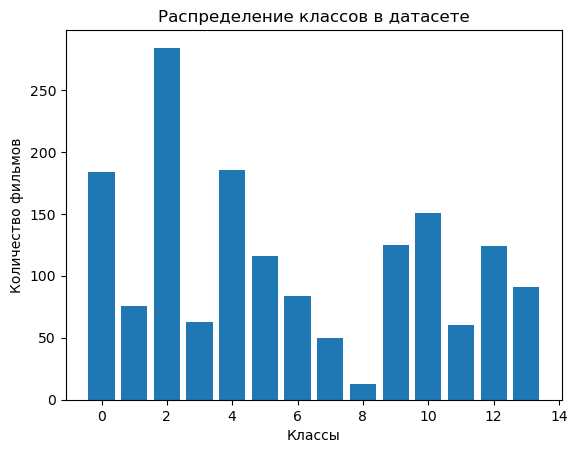

In [188]:
# Проверка сбалансированности и построение гистограммы
class_counts = check_class_balance(data["target"].values.tolist())

In [189]:
# удаляем дубликаты
data = data.drop_duplicates(subset=['plot'])

In [190]:
df = data[['plot', 'target']].copy()
df

,plot,target
0,"Действие фильма «Дивергент» происходит в мире, пережившем глобальную войну, в футуристическом Чи...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
1,Однажды ночью на вершине горы возле каменоломни Тай Лунг каким-то образом возвращается. Злодей з...,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]"
2,"Чоу возвращается в Гонконг после нескольких лет, проведённых в Сингапуре. Он заселяется в дешёвы...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
3,"Аксель Фоули вернулся в Беверли-Хиллз после того, как жизнь его дочери Джейн оказалась под угроз...","[1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"История об Ангеле Смерти, который решает взять отпуск от своих обычных обязанностей, чтобы побыт...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]"
...,...,...
566,1517 год. Полуостров Юкатан. Группа охотников одного из племён лесных майя под предводительством...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]"
567,"Фильм начинается с истории взросления дочери Александра Горина — Надежды, нам показывают основны...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]"
568,"Новоиспеченная невеста, которую выдали замуж после изнасилования, превращает жизнь своей семьи в...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]"
569,Пара вместе с дочерью получают приглашение от знакомых посетить их загородный дом. Отдых мечты в...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"


In [191]:
# посмотрим минимальное и максимальное количество токенов
plot_len_train = [len(str(i).split()) for i in df['plot']]
max(plot_len_train)

2207

In [192]:
min(plot_len_train)

11

In [193]:
pd.options.display.max_colwidth = 1000
data.sort_values('len_story').head(10)

,movie,description,plot,genres,len_desc,len_story,target
341,Всё везде и сразу (2021),"По сюжету мать семейства, иммигрантка китайского происхождения (в исполнении Мишель Йео), пытается соединиться с версиями себя из параллельных миров, чтобы спасти мультивселенную.","По сюжету мать семейства, иммигрантка китайского происхождения (в исполнении Мишель Йео), пытается соединиться с версиями себя из параллельных миров, чтобы спасти мультивселенную. Фильм состоит из трёх частей, названия которых образуют общее название фильма.","[фантастика, комедия, боевик, приключения, драма]",179,78,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]"
16,Горизонты: Часть 2 (2024),Действие фильма происходит на американском Западе во второй половине XIX века.,Действие фильма происходит на американском Западе во второй половине XIX века.,"[драма, история, боевик]",78,78,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
515,Веном 3: Последний танец (2024),Эдди Брок и его симбиот Веном пускаются в бега: за ними охотятся сразу два их мира.,Эдди Брок и его симбиот Веном пускаются в бега: за ними охотятся сразу два их мира.,"[фантастика, боевик, триллер, приключения]",83,83,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]"
145,Профиль (2018),"Фильм рассказывает о журналистке из Великобритании, внедряющейся под прикрытием в «ДАИШ».","Фильм рассказывает о журналистке из Великобритании, внедряющейся под прикрытием в «ДАИШ».","[триллер, детектив]",89,89,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
252,Синяя тюрьма: Блю Лок — Эпизод Наги (2024),"Спин-офф ""Синяя Тюрьма: Блю Лок"", который расскажет о становлении Наги Сейширо футбольным гением.","Спин-офф ""Синяя Тюрьма: Блю Лок"", который расскажет о становлении Наги Сейширо футбольным гением.","[мультфильм, драма]",97,97,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
169,Дикие истории (2014),"Фильм представляет собой черную драмеди, в которой шесть сюжетных линий пересекаются в тематике мести и ярости. Обиженный Гэбриела Пастернак оказывается в одном самолете с теми, кто когда-то его унижал. В придорожной закусочной официантка сталкивается с человеком, доведшим ее отца до самоубийства, и готовит ему ядовитую месть. Молодой водитель мощной Audi вовлечен в смертельное соревнование с провинциальным водителем старого Peugeot. Эти и другие истории переплетаются в дикой смеси триллера, комедии и драмы","Фильм представляет собой черную драмеди, в которой шесть сюжетных линий пересекаются в тематике мести и ярости. Обиженный Гэбриела Пастернак оказывается в одном самолете с теми, кто когда-то его унижал. В придорожной закусочной официантка сталкивается с человеком, доведшим ее отца до самоубийства, и готовит ему ядовитую месть. Молодой водитель мощной Audi вовлечен в смертельное соревнование с провинциальным водителем старого Peugeot. Эти и другие истории переплетаются в дикой смеси триллера, комедии и драмы Фильм состоит из шести отдельных коротких эпизодов-новелл, объединённых общей темой насилия и мести.","[триллер, драма, комедия]",512,100,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
273,Зачинщики (2024),"После неудавшегося ограбления двое воров вынуждены пуститься в бега, в этом им помогает врач-терапевт.","После неудавшегося ограбления двое воров вынуждены пуститься в бега, в этом им помогает врач-терапевт.","[боевик, триллер, драма, комедия, криминал, детектив]",102,102,"[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]"
568,Дастур (2023),"Новоиспеченная невеста, которую выдали замуж после изнасилования, превращает жизнь своей семьи в настоящий кошмар.","Новоиспеченная невеста, которую выдали замуж после изнасилования, превращает жизнь своей семьи в настоящий кошмар.","[ужасы, фантастика]",114,114,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]"
398,Тёща (2023),"Сюжет повествует о двух враждующих членах семьи: тёще и зяте, которые в результате новогоднего чуда меняются телами.","Сюжет повествует о двух враждующих членах семьи: тёще и зяте, которые в результате новогоднего чуда меняются телами.",[комедия],116,116,"[0, 0, 0, 0, 1, 0, 0, 0, 

## Создание модели ML

### Импортируем необходимые библиотеки

In [194]:
# from numba import cuda
# from itertools import islice
# import time

# from simpletransformers.classification import ClassificationModel

# import pandas as pd
# import numpy as np
from sklearn import metrics
import transformers
from transformers import BertForSequenceClassification, BertTokenizer, BertModel, BertConfig
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
# from transformers import AutoModelForMaskedLM
# from transformers import BertForMaskedLM
# import torch
from torch.utils.data import Dataset, DataLoader

# from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm

Остановились на модели 'DeepPavlov/rubert-base-cased'

In [195]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
# EPOCHS = 20
LEARNING_RATE = 5e-05

# tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
# tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

C:\Users\Animados\anaconda3\envs\tensorflow\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [196]:
class TrainDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = self.data['plot']
        self.targets = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [197]:
# Разделяем DataFrame на train и val часть
train_size = 0.8
train_dataset = df.sample(frac=train_size, random_state=seed)
val_dataset = df.drop(train_dataset.index).reset_index(drop=True)
train_dataset.reset_index(drop=True, inplace=True)

print(f"FULL dataset: {df.shape}")
print(f"TRAIN dataset: {train_dataset.shape}")
print(f"VAL dataset: {val_dataset.shape}")

FULL dataset: (571, 2)
TRAIN dataset: (457, 2)
VAL dataset: (114, 2)


Поскольку модель принимает только 512 токенов, а в некоторых описаниях более 2000 токенов, увеличим датасет, разбив на части длинные описания

In [198]:
# Функция для определения количества токенов
def count_tokens(text):
    return len(tokenizer.tokenize(text))

# Добавление нового столбца с количеством токенов
train_dataset['token_count'] = train_dataset['plot'].apply(count_tokens)

# Фильтрация строк с количеством токенов меньше 15
filtered_df = train_dataset[train_dataset['token_count'] < 15]

# Второй фильтр: условие остатка строки не менее 100 токенов
def filter_texts_with_min_tokens(text, min_tokens=100):
    tokens = tokenizer.tokenize(text)
    if len(tokens) < min_tokens:
        return []

    token_chunks = []
    current_chunk = []

    for token in tokens:
        if len(current_chunk) + 1 > 512 or (len(tokens) - len(current_chunk) < min_tokens):
            token_chunks.append(current_chunk)
            current_chunk = [token]
        else:
            current_chunk.append(token)

    if current_chunk:
        token_chunks.append(current_chunk)

    return [tokenizer.convert_tokens_to_string(chunk) for chunk in token_chunks]

In [199]:
# Создание нового DataFrame для длинных текстов
long_rows = []

# Обработка строк для получения длинных текстов
for index, row in train_dataset.iterrows():
    if row['token_count'] >= 513:
        chunks = filter_texts_with_min_tokens(row['plot'])
        for chunk in chunks:
            long_rows.append({'plot': chunk, 'target': row['target']})

# Создание нового DataFrame с длинными текстами
long_texts_df = pd.DataFrame(long_rows)

In [200]:
train_dataset = pd.concat([train_dataset, long_texts_df], ignore_index=True)

In [201]:
train_dataset = train_dataset[train_dataset['plot'].apply(lambda x: len(tokenizer.tokenize(x))) < 513]

In [202]:
train_dataset = train_dataset[train_dataset['plot'].apply(lambda x: len(tokenizer.tokenize(x))) > 18]

In [203]:
# удаляем дубликаты
train_dataset = train_dataset.drop_duplicates(subset=['plot'])
train_dataset.reset_index(drop=True, inplace=True)
print(f"TRAIN dataset: {train_dataset.shape}")

TRAIN dataset: (824, 3)


In [204]:
# Создаем наборы объектов
training_set = TrainDataset(train_dataset, tokenizer, MAX_LEN)
validation_set = TrainDataset(val_dataset, tokenizer, MAX_LEN)

Распределение классов:
Класс 0: 299
Класс 1: 116
Класс 2: 405
Класс 3: 80
Класс 4: 267
Класс 5: 199
Класс 6: 119
Класс 7: 75
Класс 8: 21
Класс 9: 210
Класс 10: 244
Класс 11: 74
Класс 12: 213
Класс 13: 141


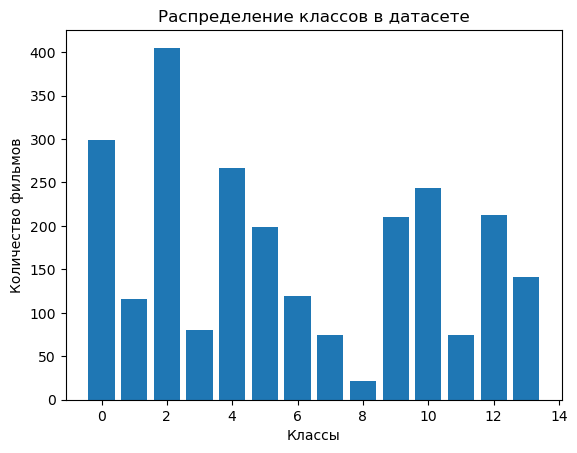

In [205]:
# Проверка сбалансированности и построение гистограммы
class_counts = check_class_balance(train_dataset["target"].values.tolist())

Так как классы не сбалансированы, то для функции потерь посчитаем корректировочные коэффициенты.

In [206]:
total_count = sum(class_counts.values())
weights = {class_id: total_count / (len(class_counts) * count) for class_id, count in class_counts.items()}

weight = torch.FloatTensor(list(weights.values()))
weight = torch.nan_to_num(weight, posinf=1.0, neginf=1.0)
weight = weight.to('cuda') / weight.min()
weight

tensor([ 1.3545,  3.4914,  1.0000,  5.0625,  1.5169,  2.0352,  3.4034,  5.4000,
        19.2857,  1.9286,  1.6598,  5.4730,  1.9014,  2.8723], device='cuda:0')

In [207]:
# Создаем DataLoader для каждого из наборов.
# DataLoader формирует батчи примеров из dataset, которые передаются в нейронную сеть

train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

val_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)

In [208]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [209]:
NUM_CLASSES = 14

class BERTClass(torch.nn.Module):
  def __init__(self, num_classes):
    super(BERTClass, self).__init__()
    # self.l1 = transformers.AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")
    # self.l1 = transformers.AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
    self.l1 = transformers.BertModel.from_pretrained('DeepPavlov/rubert-base-cased')
    self.l2 = torch.nn.Linear(768, num_classes)

  def forward(self, ids, mask, token_type_ids):
    x = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)
    x = self.l2(x['pooler_output'])
    return x


model = BERTClass(NUM_CLASSES)
model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [210]:
def loss_fn(outputs, targets, weight = None):
    return torch.nn.CrossEntropyLoss(weight)(outputs, targets)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [211]:
def train(epoch, weight = None):
    model.train()
    pbar = tqdm(training_loader)
    train_losses = []
    for _, data in enumerate(pbar, 0):
        ids = data["ids"].to(device, dtype=torch.long)
        mask = data["mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        targets = data["targets"].to(device, dtype=torch.float)

        optimizer.zero_grad() # обнуляем градиент
        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets, weight)
        loss.backward()  # вычисляем обратное распространение ошибки
        train_losses.append(loss.item())
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step() # обновляем веса модели
        optimizer.zero_grad()

        if _ % 100 == 0:
            pbar.set_description(f"Epoch: {epoch + 1}, Batch: {_}, Loss: {loss.item()}")

In [212]:
def validation():
    model.eval()
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for _, data in enumerate(tqdm(validation_loader), 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)

            # для вычисления метрик на валидации переносим данные на cpu и преобразуем к формату numpy
            fin_targets.extend(targets.cpu().detach().numpy())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy())

    # сеть выдала значения с плавающей точкой, преобразуем значения, большие threshold,
    # к 1, а меньшие threshold - к 0
    threshold = 0.85
    fin_outputs = (np.array(fin_outputs) >= threshold).astype(int)
    fin_targets = np.array(fin_targets)

    return fin_outputs, fin_targets

#### Замораживаем предобученные слои и одну эпоху учим только слой l2.

In [213]:
for name, param in model.named_parameters():
    if "l2" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-6)

In [214]:
# Проверка заморозки
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Размороженный слой: {name}")
    else:
        print(f"Замороженный слой: {name}")

Замороженный слой: l1.embeddings.word_embeddings.weight
Замороженный слой: l1.embeddings.position_embeddings.weight
Замороженный слой: l1.embeddings.token_type_embeddings.weight
Замороженный слой: l1.embeddings.LayerNorm.weight
Замороженный слой: l1.embeddings.LayerNorm.bias
Замороженный слой: l1.encoder.layer.0.attention.self.query.weight
Замороженный слой: l1.encoder.layer.0.attention.self.query.bias
Замороженный слой: l1.encoder.layer.0.attention.self.key.weight
Замороженный слой: l1.encoder.layer.0.attention.self.key.bias
Замороженный слой: l1.encoder.layer.0.attention.self.value.weight
Замороженный слой: l1.encoder.layer.0.attention.self.value.bias
Замороженный слой: l1.encoder.layer.0.attention.output.dense.weight
Замороженный слой: l1.encoder.layer.0.attention.output.dense.bias
Замороженный слой: l1.encoder.layer.0.attention.output.LayerNorm.weight
Замороженный слой: l1.encoder.layer.0.attention.output.LayerNorm.bias
Замороженный слой: l1.encoder.layer.0.intermediate.dense.weigh

In [215]:
epoch=0
train(epoch, weight)

outputs, targets = validation()

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro', zero_division=0)
f1_score_macro = metrics.f1_score(targets, outputs, average='macro', zero_division=0)

print(f"Epoch {epoch+1} - Accuracy Score = {accuracy}")
print(f"Epoch {epoch+1} - F1 Score (Micro) = {f1_score_micro}")
print(f"Epoch {epoch+1} - F1 Score (Macro) = {f1_score_macro}")

100%|██████████| 15/15 [00:03<00:00,  3.83it/s]

Epoch 1 - Accuracy Score = 0.0
Epoch 1 - F1 Score (Micro) = 0.0
Epoch 1 - F1 Score (Macro) = 0.0


Разблокируем все слои и обучим модель 10 эпох

В качестве шедулера возьмем OneCycleLR - он плавно повышает LR до целевого значения и потом сильно понижает его.

In [216]:
for param in model.parameters():
    param.requires_grad = True

epochs = 21
best_f1  = f1_score_macro
best_cnt = 0

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=5e-5,
                                                   div_factor=10.0, final_div_factor=10.0,
                                                   steps_per_epoch=1)

In [67]:
%%time

i=0

for epoch in range(epochs):
    i = i+1
    if i == epochs:
        break
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Start epoch {epoch + 1} at {datetime.now().strftime('%H:%M:%S')}, lr={current_lr:0.8f}")
    train(epoch, weight)
    outputs, targets = validation()
    lr_scheduler.step()
    model.eval()
    torch.cuda.empty_cache()
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro', zero_division=0)
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro', zero_division=0)
    print(f"Epoch {epoch+1} - Accuracy Score = {accuracy}")
    print(f"Epoch {epoch+1} - F1 Score (Micro) = {f1_score_micro}")
    print(f"Epoch {epoch+1} - F1 Score (Macro) = {f1_score_macro}")
    
    if f1_score_macro > best_f1:
        best_f1 = f1_score_macro
        best_cnt = 0
        torch.save(model.state_dict(), "model_BERT_10.pth")
        print("Saved best model!")
    else:
        best_cnt += 1
    if best_cnt > 2:
        best_cnt = 0
        print("Loading best model weights!")
        model.load_state_dict(torch.load("model_BERT_10.pth"))

Start epoch 1 at 12:51:48, lr=0.00000500


100%|██████████| 15/15 [00:02<00:00,  6.16it/s]


Epoch 1 - Accuracy Score = 0.0
Epoch 1 - F1 Score (Micro) = 0.0
Epoch 1 - F1 Score (Macro) = 0.0
Start epoch 2 at 12:52:41, lr=0.00000884


100%|██████████| 15/15 [00:02<00:00,  5.91it/s]


Epoch 2 - Accuracy Score = 0.0
Epoch 2 - F1 Score (Micro) = 0.0
Epoch 2 - F1 Score (Macro) = 0.0
Start epoch 3 at 12:53:38, lr=0.00001904


100%|██████████| 15/15 [00:02<00:00,  5.93it/s]


Epoch 3 - Accuracy Score = 0.0
Epoch 3 - F1 Score (Micro) = 0.019736842105263157
Epoch 3 - F1 Score (Macro) = 0.017857142857142856
Saved best model!
Start epoch 4 at 12:54:35, lr=0.00003213


100%|██████████| 15/15 [00:02<00:00,  5.92it/s]


Epoch 4 - Accuracy Score = 0.017543859649122806
Epoch 4 - F1 Score (Micro) = 0.2613333333333333
Epoch 4 - F1 Score (Macro) = 0.3051956521991365
Saved best model!
Start epoch 5 at 12:55:33, lr=0.00004364


100%|██████████| 15/15 [00:02<00:00,  5.85it/s]


Epoch 5 - Accuracy Score = 0.05263157894736842
Epoch 5 - F1 Score (Micro) = 0.35046728971962615
Epoch 5 - F1 Score (Macro) = 0.37104096426069877
Saved best model!
Start epoch 6 at 12:56:31, lr=0.00004965


100%|██████████| 15/15 [00:02<00:00,  5.94it/s]


Epoch 6 - Accuracy Score = 0.07017543859649122
Epoch 6 - F1 Score (Micro) = 0.501002004008016
Epoch 6 - F1 Score (Macro) = 0.4851973863237809
Saved best model!
Start epoch 7 at 12:57:28, lr=0.00004972


100%|██████████| 15/15 [00:02<00:00,  5.90it/s]


Epoch 7 - Accuracy Score = 0.08771929824561403
Epoch 7 - F1 Score (Micro) = 0.5330812854442344
Epoch 7 - F1 Score (Macro) = 0.5483357166676911
Saved best model!
Start epoch 8 at 12:58:26, lr=0.00004838


100%|██████████| 15/15 [00:02<00:00,  5.94it/s]


Epoch 8 - Accuracy Score = 0.12280701754385964
Epoch 8 - F1 Score (Micro) = 0.610051993067591
Epoch 8 - F1 Score (Macro) = 0.5795291772215628
Saved best model!
Start epoch 9 at 12:59:24, lr=0.00004599


100%|██████████| 15/15 [00:02<00:00,  5.82it/s]


Epoch 9 - Accuracy Score = 0.10526315789473684
Epoch 9 - F1 Score (Micro) = 0.6290322580645161
Epoch 9 - F1 Score (Macro) = 0.5716509505156029
Start epoch 10 at 13:00:21, lr=0.00004266


100%|██████████| 15/15 [00:02<00:00,  5.87it/s]


Epoch 10 - Accuracy Score = 0.11403508771929824
Epoch 10 - F1 Score (Micro) = 0.6258278145695364
Epoch 10 - F1 Score (Macro) = 0.5634338362285821
Start epoch 11 at 13:01:18, lr=0.00003853


100%|██████████| 15/15 [00:02<00:00,  5.96it/s]


Epoch 11 - Accuracy Score = 0.09649122807017543
Epoch 11 - F1 Score (Micro) = 0.6293929712460063
Epoch 11 - F1 Score (Macro) = 0.6259870017537438
Saved best model!
Start epoch 12 at 13:02:16, lr=0.00003380


100%|██████████| 15/15 [00:02<00:00,  5.88it/s]


Epoch 12 - Accuracy Score = 0.15789473684210525
Epoch 12 - F1 Score (Micro) = 0.6459627329192547
Epoch 12 - F1 Score (Macro) = 0.6493471276203274
Saved best model!
Start epoch 13 at 13:03:14, lr=0.00002868


100%|██████████| 15/15 [00:02<00:00,  5.84it/s]


Epoch 13 - Accuracy Score = 0.14912280701754385
Epoch 13 - F1 Score (Micro) = 0.6543778801843319
Epoch 13 - F1 Score (Macro) = 0.6496023029633565
Saved best model!
Start epoch 14 at 13:04:12, lr=0.00002340


100%|██████████| 15/15 [00:02<00:00,  5.97it/s]


Epoch 14 - Accuracy Score = 0.12280701754385964
Epoch 14 - F1 Score (Micro) = 0.6696969696969697
Epoch 14 - F1 Score (Macro) = 0.6593870637932903
Saved best model!
Start epoch 15 at 13:05:10, lr=0.00001821


100%|██████████| 15/15 [00:02<00:00,  5.93it/s]


Epoch 15 - Accuracy Score = 0.13157894736842105
Epoch 15 - F1 Score (Micro) = 0.6676470588235294
Epoch 15 - F1 Score (Macro) = 0.6552621627503195
Start epoch 16 at 13:06:07, lr=0.00001334


100%|██████████| 15/15 [00:02<00:00,  5.88it/s]


Epoch 16 - Accuracy Score = 0.10526315789473684
Epoch 16 - F1 Score (Micro) = 0.6637298091042585
Epoch 16 - F1 Score (Macro) = 0.6122684138334173
Start epoch 17 at 13:07:04, lr=0.00000901


100%|██████████| 15/15 [00:02<00:00,  5.88it/s]
<timed exec>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Epoch 17 - Accuracy Score = 0.12280701754385964
Epoch 17 - F1 Score (Micro) = 0.6695652173913044
Epoch 17 - F1 Score (Macro) = 0.6179166148784392
Loading best model weights!
Start epoch 18 at 13:08:01, lr=0.00000542


100%|██████████| 15/15 [00:02<00:00,  6.07it/s]


Epoch 18 - Accuracy Score = 0.10526315789473684
Epoch 18 - F1 Score (Micro) = 0.6756352765321375
Epoch 18 - F1 Score (Macro) = 0.6220612824914493
Start epoch 19 at 13:08:55, lr=0.00000273


100%|██████████| 15/15 [00:02<00:00,  5.84it/s]


Epoch 19 - Accuracy Score = 0.11403508771929824
Epoch 19 - F1 Score (Micro) = 0.6646706586826348
Epoch 19 - F1 Score (Macro) = 0.6072973761724899
Start epoch 20 at 13:09:53, lr=0.00000106


100%|██████████| 15/15 [00:02<00:00,  5.87it/s]
<timed exec>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Epoch 20 - Accuracy Score = 0.12280701754385964
Epoch 20 - F1 Score (Micro) = 0.6776119402985075
Epoch 20 - F1 Score (Macro) = 0.6193466173899245
Loading best model weights!
CPU times: total: 17min 27s
Wall time: 19min 2s


In [107]:
# Сохранение весов модели для дальнейшего использования
torch.save(model.state_dict(), 'Task3_final24_Bert_25_split_LB_64.232_20epoch_seed_110.pth')

### Оценим результат визуально

In [69]:
# Вывод примеров предсказаний
predicted_classes = mlb.inverse_transform(outputs)
for i in range(20):
    print(f'Predicted genres: {predicted_classes[i]}, True genres: {mlb.inverse_transform(targets)[i]}')

Predicted genres: ('детектив', 'драма', 'ужасы', 'фэнтези'), True genres: ('детектив', 'триллер', 'ужасы')
Predicted genres: ('боевик', 'драма', 'криминал', 'триллер'), True genres: ('боевик', 'криминал', 'триллер')
Predicted genres: ('драма', 'криминал', 'триллер'), True genres: ('боевик', 'триллер')
Predicted genres: ('детектив', 'ужасы'), True genres: ('драма', 'ужасы')
Predicted genres: ('боевик', 'драма', 'комедия'), True genres: ('боевик', 'приключения', 'фантастика')
Predicted genres: ('детектив', 'драма', 'ужасы'), True genres: ('ужасы',)
Predicted genres: ('драма', 'криминал', 'триллер'), True genres: ('боевик', 'триллер')
Predicted genres: ('драма', 'комедия', 'криминал'), True genres: ('комедия', 'мелодрама')
Predicted genres: ('драма', 'комедия', 'мелодрама'), True genres: ('комедия', 'мелодрама')
Predicted genres: ('драма', 'история', 'мелодрама'), True genres: ('драма', 'история', 'мелодрама')
Predicted genres: ('драма', 'триллер', 'ужасы'), True genres: ('драма', 'трилле

## Предсказания на тестовом наборе

In [70]:
import pandas as pd
import numpy as np
import transformers
import torch

from sklearn import metrics
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm

In [71]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [72]:
df = pd.read_csv('public_test.csv')
df = df.rename({'Фильм': 'movie', 'Сюжет': 'plot', 'Описание': 'description'}, axis=1)
df

,movie,description,plot
0,Убойные каникулы (2010),"Двое простых деревенских парней Дейл и Такер едут отдохнуть на дачу в лесу, которую купил Такер. В те же окрестности направляется группа студентов, желая хорошо отдохнуть, но рассказанная однокурсником страшилка о резне, произошедшей 20 лет назад, заставляет не на шутку испугаться.","Двое простых деревенских парней Дейл и Такер едут отдохнуть на дачу в лесу, которую купил Такер. В те же окрестности направляется группа студентов, желая хорошо отдохнуть, но рассказанная однокурсником страшилка о резне, произошедшей 20 лет назад, заставляет не на шутку испугаться. \n\n\nНочью студенты идут купаться. Студентка Эллисон отошла подальше, чтобы поплавать в одиночестве, но её пугает Дейл, рыбачащий неподалёку, и она падает в воду. Эллисон ударяется головой о камень и начинает тонуть, Дейл и Такер спасают её, а студенты решают, что её похитили.\n\n\nКогда девушка приходит в сознание, она знакомится с Дейлом. Они играют в настольные игры, затем Эллисон помогает Дейлу рыть выгребную яму, а студенты решают, что маньяки заставили её копать себе могилу. Они пытаются спасти её, но трое случайно погибают — один напарывается на сук, убегая от Такера, размахивающего бензопилой (Такер случайно распилил улей, который был в бревне, и убегал от пчёл), другой протыкает себя колом, упа..."
1,"Три билборда на границе Эббинга, Миссури (2017)","После того как убийцы её дочери не были найдены, Милдред Хейс решает действовать. Она арендует три билборда на въезде в город Эббинг, штат Миссури, и размещает на них послания к шерифу Биллу Уиллоуби: «Изнасилована, пока умирала», «Все ещё нет арестов?» и «Как так случилось, шериф Уиллоуби?» Эти билборды вызывают бурю недовольства у жителей города и самого шерифа, который страдает от рака поджелудочной железы. В конфликт вмешивается заместитель шерифа Джейсон Диксон, инфантильный и склонный к насилию, который начинает применять свои методы, чтобы вернуть ситуацию под контроль. Милдред продолжает бороться за справедливость, несмотря на растущее давление и угрозы.","В вымышленном городе Эббинг, штат Миссури, Милдред Хейс (Фрэнсис Макдорманд) оплакивает изнасилование и убийство своей дочери-подростка Анджелы, совершенные несколькими месяцами ранее. Раздраженная отсутствием прогресса в расследовании, Милдред арендует три заброшенных билборда возле своего дома и размещает на них сообщения: «Изнасилована, пока умирала», «Все ещё нет арестов?» и «Как так случилось, шериф Уиллоуби?» Рекламные щиты расстроили горожан, в том числе шерифа Билла Уиллоуби (Вуди Харрельсон) и полицейского Джейсона Диксона (Сэм Рокуэлл), расиста и алкоголика. Ни для кого не секрет, что Билл страдает от неизлечимого рака поджелудочной железы, что также добавляет недовольства по поводу билбордов. Несмотря на оскорбления и угрозы, а также возражения со стороны сына Робби, Милдред по-прежнему полна решимости отстаивать идею с рекламными щитами.\n\n\nХотя Билл с пониманием относится к разочарованию Милдред, он считает рекламные щиты нечестным поступком по отношению к нему самом..."
2,Глубоководный горизонт (2016),"История о катастрофе на нефтяной платформе «Глубоководный горизонт» в 2010 году в Мексиканском заливе, когда недооценка рисков и нарушения процедур привели к одной из самых масштабных техногенных аварий в истории. Хроника мужества и самопожертвования людей, столкнувшихся с трагедией, и их борьбы за выживание.","20 апреля 2010 года Deepwater Horizon, нефтяная платформа, эксплуатируемая частным подрядчиком Transocean, завершит бурение у южного побережья Луизианы по поручению BP. Главный техник по электронике Майкл «Майк» Уильямс и менеджер по монтажу на шельфе Джеймс «Мистер Джимми» Харрелл с удивлением узнают, что рабочие, назначенные для проверки целостности недавно завершенных цементных работ, были отправлены домой пораньше, без ведения журнала фиксации цемента (CBL), по настоянию менеджеров BP Дональда Видрина и Роберт Калуца.\n\n\nПока Майк готовит буровую команду, включая Калеба Холлоуэ

In [73]:
df.isnull().any()

movie          False
description    False
plot            True
dtype: bool

In [74]:
df['plot'].fillna(df['description'], inplace=True)
df.isnull().any()

C:\Users\Animados\AppData\Local\Temp\ipykernel_2112\2100915472.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['plot'].fillna(df['description'], inplace=True)


movie          False
description    False
plot           False
dtype: bool

In [75]:
import re

for i in range(len(df)):
    it_1 = re.sub(r'[\n]', ' ', df['plot'][i])
    it_2 = re.sub(r'\s+', ' ', it_1)
    df.loc[i, "plot"] = re.sub(r'\[[\d\w\.]+\]', '', it_2)

In [76]:
for i in range(len(df)):
    it_1 = re.sub(r'[\n]', ' ', df['description'][i])
    it_2 = re.sub(r'\s+', ' ', it_1)
    df.loc[i, "description"] = re.sub(r'\[[\d\w\.]+\]', '', it_2)

In [77]:
# объединим такие ячейки
df.loc[(df['description'].str.slice(0, 13) != df['plot'].str.slice(0, 13)), 'plot'] = df['description'] + ' ' + df['plot']

In [78]:
# посмотрим минимальное и максимальное количество токенов
plot_len_train = [len(str(i).split()) for i in df['plot']]
max(plot_len_train)

1556

In [79]:
min(plot_len_train)

19

In [80]:
MAX_LEN = 512

# tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
# tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
class TestDataset(Dataset):

  def __init__(self, dataframe, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.data = dataframe
    self.text = self.data['plot']
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    text = str(self.text[index])

    inputs = self.tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True
    )
    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return {
        'ids': torch.tensor(ids, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.long),
        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
    }

C:\Users\Animados\anaconda3\envs\tensorflow\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [81]:
public_set = TestDataset(df, tokenizer, MAX_LEN)
public_dataloader = DataLoader(public_set, batch_size=16, shuffle=False)

In [82]:
NUM_CLASSES = 14

class BERTClass(torch.nn.Module):
  def __init__(self, num_classes):
    super(BERTClass, self).__init__()
    # self.l1 = transformers.AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")
    # self.l1 = transformers.AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
    self.l1 = transformers.BertModel.from_pretrained('DeepPavlov/rubert-base-cased')
    self.l2 = torch.nn.Linear(768, num_classes)

  def forward(self, ids, mask, token_type_ids):
    x = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)
    x = self.l2(x['pooler_output'])
    return x


model = BERTClass(NUM_CLASSES)
model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [83]:
path_to_weights = './model_BERT_10.pth'
model.load_state_dict(torch.load(path_to_weights))

C:\Users\Animados\AppData\Local\Temp\ipykernel_2112\814013193.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_to_weights))


<All keys matched successfully>

In [102]:
model.eval()
fin_outputs = []

with torch.no_grad():
    for data in tqdm(public_dataloader):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

        outputs = model(ids, mask, token_type_ids)

        fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

threshold = 0.85
fin_outputs = (np.array(fin_outputs) >= threshold).astype(int)

100%|██████████| 8/8 [00:03<00:00,  2.63it/s]


In [103]:
genres = ['боевик', 'детектив', 'драма', 'история', 'комедия', 'криминал',
       'мелодрама', 'мультфильм', 'мюзикл', 'приключения', 'триллер',
       'ужасы', 'фантастика', 'фэнтези']

In [104]:
def replace_and_join(array, genres):
    result = []
    for row in array:
        genre_indices = np.where(row == 1)[0]
        genre_names = [genres[i] for i in genre_indices]
        result.append(", ".join(genre_names))
    return result

answers = replace_and_join(fin_outputs, genres)

In [105]:
answers_df = df[['movie']].copy()
answers_df['genres'] = answers
answers_df = answers_df.rename({'movie': 'Фильм', 'genres': 'Жанры'}, axis=1)
answers_df

,Фильм,Жанры
0,Убойные каникулы (2010),"драма, триллер, ужасы"
1,"Три билборда на границе Эббинга, Миссури (2017)","детектив, драма, криминал, триллер"
2,Глубоководный горизонт (2016),"драма, история, триллер, ужасы"
3,Главный герой (2021),"боевик, комедия, фантастика"
4,Мистер и миссис Смит (2005),"боевик, драма, криминал, триллер"
...,...,...
117,Белая птица: Новое чудо (2023),"боевик, драма, история"
118,Манюня: Приключения в Москве (2024),комедия
119,Мадагаскар (2005),"криминал, мультфильм, приключения"
120,Взаперти (2020),"драма, мелодрама, триллер"


In [106]:
answers_df.to_csv(f'submit_v25-split_threshold85_seed_{seed}.csv', index=False)